In [12]:
using LinearAlgebra
using Plots
using Printf
using SparseArrays
using Arpack
using Statistics
using LaTeXStrings

In [3]:
function func_DQMC(hopping_matrix,U,beta,N_x,N_y,dT,dk,n_markov,N_sw_warm_up,N_sw_measurement,measurement_time_step,swtch_correlation)
    
    N_s = N_x * N_y; #Number of sites
    
    N_T = Int(max(dk,round(beta/dT)));#number of tiem steps
    dT = beta/N_T; #time step
    lambda = acosh(exp(U*dT/2));
    
    # to be used for Green's function evaluation and space-time wrap
    k_vec = zeros(1,N_T);
    k_vec[dk:dk:N_T] .= 1;
    k_vec[N_T] = 1;
    k_vec = vec(k_vec);
    
    # to be used for two-point correlation functions
    range_corr_x = collect(1:N_x);
    range_corr_y = collect(1:N_y);
    
    ###############################################
    #  computing expm(KdT), expm...........
    ###############################################
    
    D0, U0 = eigen(hopping_matrix);
    D0_d = D0;
    B = U0*Diagonal(exp.(-dT*D0_d))*U0';
    B_root = U0*Diagonal(exp.(-dT*D0_d/2))*U0';
    inv_B = U0*Diagonal(exp.(dT*D0_d))*U0';
    inv_B_root = U0*Diagonal(exp.(dT*D0_d/2))*U0';
    
    #######################################
    num_samples_avg = zeros(n_markov,1);
    Sgn_avg = Array{Any}(undef,n_markov);
    GF_up_avg = Array{Any}(undef,n_markov);
    GF_dn_avg = Array{Any}(undef,n_markov);
    n_up_dn_avg = Array{Any}(undef,n_markov);
    two_point_corr_avg = Array{Any}(undef,n_markov,3,N_x);
    swtch_time_measurement = 0;
    
    for count = 1:n_markov

        progress = [count count/n_markov*100]
        @printf("Progress = %s\n", (Int.(progress)))
        
        # Initalization:
        num_samples = 0;
        Sgn_Z = 0;
        
        two_point_corr = Array{Any}(undef,3,N_x);
        n_up_dn = zeros(N_s);
        GF_up = zeros(N_s,N_s);
        GF_dn = zeros(N_s,N_s);
        for m1 = 1:3
            two_point_corr[m1,:] .= 0 ;
        end
        #println(two_point_corr[1])
        # Initialization with a random seed for Hubbard-Stratonovic fields:
        s = rand([-1,1],(N_T,N_s)); #Initializing Hubbard-Stratonivc fields witha random binary values
        h = lambda*s; # h_up = lambda*s    ,     h_dn = -h_up = -lambda*s
        
        
        # computing corresponding Green's functions for up and down spin electrons
        B_up_cell = Cluster(B,inv_B,h,N_T);  # computing B_up(l) = exp(-KdT)exp(-h_up(l)) for all l = 1:N_T      h_up =  h =  lambda*s
        B_dn_cell = Cluster(B,inv_B,-h,N_T); # computing B_dn(l) = exp(-KdT)exp(-h_dn(l)) for all l = 1:N_T      h_dn = -h = -lambda*s
        # Using QR decomposition to stabilize B_L ... B_1 to compute G = inv(Id + B_L ... B_1)  for B = B_up or B_dn
        G_up,G_dn,log_det_G,sign_det_G = Initial_Evaluation(B_up_cell,B_dn_cell,k_vec,N_T);
        
        # initial sign of det(Z) = 1/det(G_up*G_dn)
        # thge sign of various HS fields/configs is needed for computing expectation values
        sgn_Z_accumulated = sign_det_G;
        
        # Space-time sweeps:
        for nsw = 1:(N_sw_warm_up+N_sw_measurement)
            # loop over various time-slices
            # Green's function is reevaluated for stability reason every dk steps
            for l = 1: N_T
                
                # Green's function update upon Hubbard-Stratonovic fields flip
                # using Sherman-Morrison update method
                G_up,G_dn,h,sgn_Z_accumulated_tmp = Sher_Mor(G_up,G_dn,h,N_s);
                
                ### Indeed for N_s > ~50, it is way faster to use delayed update
                # method which is based on Sherman-Morrison-Woodbury
                ## delayed_period = 32;
                ## [G_up,G_dn,h,sgn_Z_accumulated_tmp] = Delayed_update(G_up,G_dn,h,N_s,delayed_period);

                ### note that we need the sign of current GF with respect to the first GF so: sgn_current = sgn_prev*sgn_tmp
                sgn_Z_accumulated = sgn_Z_accumulated*sgn_Z_accumulated_tmp;
                ## space time wrap up by one time-step
                h = circshift(h,[-1,0]);
                k_vec = circshift(k_vec,-1);
                
                if k_vec[l] == 1
                    ### reevaluation the Green's function from scratch
                    B_up_cell = Cluster(B,inv_B,h,N_T);
                    B_dn_cell = Cluster(B,inv_B,-h,N_T);
                    
                    G_up,G_dn,doe1,doe2 = Initial_Evaluation(B_up_cell,B_dn_cell,k_vec,N_T);
                    
                else
                   ### spacetime wrapping using already existing Green's functions
                    h_tmp = h[N_T,:];

                    # spin up
                    B_up_prev = B*Diagonal(exp.(h_tmp));
                    inv_B_up_prev = Diagonal(exp.(-h_tmp))*inv_B;
                    G_up = B_up_prev*G_up*inv_B_up_prev;

                    # spin dn
                    B_dn_prev = B*Diagonal(exp.(-h_tmp));
                    inv_B_dn_prev = Diagonal(exp.(h_tmp))*inv_B;
                    G_dn = B_dn_prev*G_dn*inv_B_dn_prev;
                end
                
                ## checks whether or not measurements are in order in this time-step
                if mod(l-1,measurement_time_step) == 0
                    swtch_time_measurement = 1;
                end
                if  nsw > N_sw_warm_up
                    if swtch_time_measurement == 1
                        num_samples = num_samples + 1;

                        Sgn_Z = Sgn_Z + sgn_Z_accumulated;

                        ### inv_B_root*G_up*B_root & inv_B_root*G_dn*B_root
                        ### instead of G_up and G_dn are used to employ the
                        ### 2nd order Trotter-Suzuki decomposition (which is more accurate)
                        GF_up_tmp = Matrix(I,N_s,N_s) - inv_B_root*G_up*B_root;
                        GF_dn_tmp = Matrix(I,N_s,N_s) - inv_B_root*G_dn*B_root;

                        ### spin-dependent density profile for current Hubbard-Stratonbvic fields
                        n_up_tmp = diag(GF_up_tmp);
                        n_dn_tmp = diag(GF_dn_tmp);
                        
                        ### spin sz and total density profile for current Hubbard-Stratonbvic fields
                        sz_tmp  = (n_up_tmp - n_dn_tmp)/2;
                        rho_tmp = (n_up_tmp + n_dn_tmp)/2;
                        #### to compute average GF and <n_up n_dn>
                        GF_up = GF_up + GF_up_tmp*sgn_Z_accumulated;
                        GF_dn = GF_dn + GF_dn_tmp*sgn_Z_accumulated;

                        n_up_dn = n_up_dn + n_up_tmp.*n_dn_tmp*sgn_Z_accumulated;

                        ### more two-point correlation functions: spin-spin
                        # and density-density correlation functions along x axis
                        ### namely: <O(x0,y0)O(x0+x,y0)>
                        if swtch_correlation == 1
                            corr_tmp = Array{Any}(undef,3,N_x);
                            
                            ## ============ ============ ============ ============ %%%%%
                            ### ============ Correlations along X axis ===========
                            ## ============ ============ ============ ============ %%%%%
                            
                            corr_0 = Array{Any}(undef,3,N_x);
                            for m1 = 1:3
                                corr_0[m1,:] .= 0;
                            end
                            count_tmp = 0;
                            
                            for nx_1 = range_corr_x,ny_1 = range_corr_y
                                R1_0 = [nx_1-1]*N_y .+ ny_1; ### first coordinate of the correlation function
                                R2_0 = N_y*[nx_1:N_x ; 1:nx_1-1] .- N_y .+ ny_1; ### 2nd coordinate of the correlation function
                                
                                #### <sz(R1_0)sz(R2_0)> computation
                                corr_tmp[1,:] = (sz_tmp[R1_0].*sz_tmp[R2_0])' -  (GF_up_tmp[R1_0,R2_0].*GF_up_tmp[R2_0,R1_0]')/4 -(GF_dn_tmp[R1_0,R2_0].*GF_dn_tmp[R2_0,R1_0]')/4;
                                corr_tmp[1,1] = -(n_up_tmp[R1_0][1]*n_dn_tmp[R1_0][1])/2 + (rho_tmp[R1_0][1])/2;  

                                #### <sx(R1_0)sx(R2_0)> computation
                                corr_tmp[2,:] = -GF_up_tmp[R1_0,R2_0].*(GF_dn_tmp[R2_0,R1_0]')/2;
                                corr_tmp[2,1] = n_up_tmp[R1_0][1]*(1-n_dn_tmp[R1_0][1])/2;
                                
                                #### <rho(R1_0)\rho(R2_0)> computation
                                corr_tmp[3,:] =  (rho_tmp[R1_0][1].*rho_tmp[R2_0])' - (GF_up_tmp[R1_0,R2_0].*GF_up_tmp[R2_0,R1_0]')/4  -(GF_dn_tmp[R1_0,R2_0].*GF_dn_tmp[R2_0,R1_0]')/4;
                                corr_tmp[3,1] = (n_up_tmp[R1_0][1]*n_dn_tmp[R1_0][1])/2 + rho_tmp[R1_0][1]/2;
                                
                                
                                for m1 = 1 : 3
                                    corr_0[m1,:] = corr_0[m1,:] + corr_tmp[m1,:];
                                end
                                count_tmp = count_tmp + 1;
                            end
                        end
                        
                        for m1 = 1 : 3
                            corr_0[m1,:] = corr_0[m1,:]/count_tmp;
                        end

                        for m1 = 1 : 3
                            two_point_corr[m1,:] = two_point_corr[m1,:] + corr_0[m1,:].*sgn_Z_accumulated;
                        end
                    end
                end
            end
        end
        
        ###<O> =  <Osign(Z)>/<sign(Z)>
        GF_up_avg[count] = GF_up/Sgn_Z;
        GF_dn_avg[count] = GF_dn/Sgn_Z;
        n_up_dn_avg[count] = n_up_dn/Sgn_Z;

        for m1 = 1:3
            two_point_corr_avg[count,m1,:] = two_point_corr[m1,:]/Sgn_Z;
        end
        num_samples_avg[count] = num_samples;
        Sgn_avg[count] = Sgn_Z/num_samples; ### average sign of fermion determinantsZ, where Z = 1/(Det(G_up)Det(G_dn)) for a given Hubbard-Stratonvic field
    end
    ### expection values for each markov chain is stored in a cell structure
    ###  for final statistical average in a separate function
    correlations_tmp = Array{Any}(undef,4);
    correlations_tmp[1] = GF_up_avg;
    correlations_tmp[2] = GF_dn_avg;
    correlations_tmp[3] = n_up_dn_avg;
    correlations_tmp[4] = two_point_corr_avg;

    #### saving average spin and of number of samples related to partition
    #### function in another cell structure.
    par_func_tmp = Array{Any}(undef,2);
    par_func_tmp[1] = num_samples_avg;
    par_func_tmp[2] = Sgn_avg;
    
    return par_func_tmp,correlations_tmp
end                 

func_DQMC (generic function with 1 method)

In [4]:
function Cluster(B_K,inv_B_K,h,N_T)
    
    # Here we compute B_up(l) = exp(-KdT)exp(-h_up(l)) & B_dn(l) = exp(-KdT)exp(-h_dn(l)) where h_up = -h_dn = h
    # We also compute inv(B_up(l)) = exp(h_up(l))exp(KdT) & inv(B_dn(l)) = exp(h_dn(l))exp(KdT)
    h = sparse(h);
    B = Array{Any}(undef,N_T);
    inv_B = Array{Any}(undef,N_T);
    for l=1:N_T
        h_tmp = h[l,:];
        
        B[l] = B_K*Diagonal(exp.(h_tmp));
        inv_B[l] = Diagonal(exp.(-h_tmp))*inv_B_K;

    end
    return B
end

Cluster (generic function with 1 method)

In [29]:
function Strat(B,k_vec,N_T)
    
    Q = 1;
    D = 1;
    T = 1;
    ii = 1;

    while ii <= N_T
        
        B0 = B[ii];
        ii = ii +  1;
        while ii <= N_T && k_vec[ii] < 1

            B0 = B[ii]*B0;
            ii = ii + 1;
        end
        C = (B0*Q)*D;
        
        Q,R = qr(C);
        D0 = sparse(diag(R));
        inv_D = sparse(Diagonal(D0.^-1));
        D = Diagonal(D0);
        T = (inv_D*R)*T;
    end

    D_diag = vec(diag(D));
    
    D_b = ones(length(D_diag));
    D_s = ones(length(D_diag));
    
    ind_max = findall((abs.(D_diag).-1).>0);
    ind_min = findall((abs.(D_diag).-1).<0);
    D_b[ind_max] = D_diag[ind_max];
    D_s[ind_min] = D_diag[ind_min]
    D_b = D_b.*sign.(D_diag);

    
    inv_D_b = sparse(Diagonal(D_b.^-1));
    D_s = sparse(Diagonal(D_s));

    A1 = (inv_D_b*(Q') + D_s*T);
    A2 = Matrix(inv_D_b);
    A3 = sparse(Q');
    G = (A1\A2) * A3
    #G = (inv(A1)*A2)*A3;
    
    ## computing log(det(abs(G))) as well as sign(det(G)) accurately and with special care (again to avoid numerical instabilities)
    L1,U1,p = lu(A1);
    
    log_det_L1 = 0;
    sign_det_L1 = sign(det(L1));
    log_det_U1 = sum(log.(abs.(diag(U1))));
    sign_det_U1 = prod(sign.(diag(U1)));
    
    log_det_A1 = log_det_L1 + log_det_U1;
    sign_det_A1 = sign_det_L1*sign_det_U1;
    
    log_det_A2 = -sum(log.(broadcast(abs,D_b)));
    sign_det_A2 = prod(sign.(D_b));
    
    log_det_A3 = 0;
    sign_det_A3 = sign(det(A3));

    sign_det_G = sign_det_A1*sign_det_A2*sign_det_A3; #sign of det(G)
    log_det_G = -log_det_A1+log_det_A2+log_det_A3; #log of abs(det(G))
    
    return G,log_det_G,sign_det_G
    
end 

Strat (generic function with 1 method)

In [19]:
function Initial_Evaluation(B_up_hat,B_dn_hat,k_vec,N_T)
    
    #Here we use startification & QR decomposition to compute the GF from scratch
    ###################
    #  Stratification
    ###################
    
    # Spin up:
    G_p,log_det_G_p,sign_det_G_p = Strat(B_up_hat,k_vec,N_T);
    
    # Spin down:
    G_m,log_det_G_m,sign_det_G_m = Strat(B_dn_hat,k_vec,N_T);
    
    log_det_G = log_det_G_p + log_det_G_m; #log of asb val of det(G_up*G_dn)
    sign_det_G = sign_det_G_p*sign_det_G_m; #sin of abs val of det(G_dn*G_dn)
    
    return G_p,G_m,log_det_G,sign_det_G
    
end

Initial_Evaluation (generic function with 1 method)

In [20]:
function Sher_Mor(G_up,G_dn,h,N_s)
    
    Id = Matrix(I,N_s,N_s);
    sgn_accumulated_tmp = 1;
    
    for i1 = 1:N_s
        ### ratio of 1/det(G_up)
        alpha_up = exp.(-2*h[1,i1]) - 1;
        r_up = 1 + alpha_up*(1-G_up[i1,i1]);
        
        ### ratio of 1/det(G_dn)
        alpha_dn = exp.(+2*h[1,i1]) - 1;
        r_dn = 1 + alpha_dn*(1-G_dn[i1,i1]);
        
        #total ratio
        r = r_up*r_dn;
        
        # Hubbard-Stratonic field flip acceptance based on Metropolis-Hasting algorithm
        # as a consequence Green's function update based on the Sherman-Morrison update formula

        if rand(1)[1] <= abs(r)
            
            # spin up GF update:
            a_up = (Id - G_up);
            b_up = G_up;
            G_up = G_up - (alpha_up/r_up)*a_up[:,[i1]]*b_up[[i1],:];
           
            #  spin dn GF update:
            a_dn = (Id - G_dn);
            b_dn = G_dn;
            G_dn = G_dn - (alpha_dn/r_dn)*a_dn[:,[i1]]*b_dn[[i1],:];
            
            # update h of accumulated sign of det
            h[1,i1] = -h[1,i1];
            sgn_accumulated_tmp = sgn_accumulated_tmp * sign.(r);
            
        end
    end

    return G_up,G_dn,h,sgn_accumulated_tmp
end

Sher_Mor (generic function with 1 method)

In [21]:
function Hopping_matrix(t_x,t_y,t_xy,N_x,N_y,bnd_x,bnd_y)
    
    # Constructing the matrix of hopping amplitudes for a 2D square lattice
    dx = 1;
    rx_max = dx; #range of hopping along x
    
    if N_x == 1
        rx_max = 0;
    elseif N_x < 5
        rx_max = 1;
    end
    
    dy = 1;
    ry_max = dx; #range of hopping along y
    
    if N_y == 1
        ry_max = 0;
    elseif N_y < 5
        ry_max = 1;
    end
    
    # hopping amplitudes from sit i to its nearest and next nearest neighbors
    T = -[t_xy     t_x   t_xy;
     t_y      0     t_y;
     t_xy     t_x   t_xy];
    
    # hopping matrix
    H0 = zeros(N_x*N_y,N_x*N_y);
    for i1 = 1:N_x, i2 = 1:N_y
        
        r1 = (i1-1)*N_y + i2; #index of site r1 = (i1,i2)
        for rx = -rx_max:rx_max
            j1 = i1 + rx;
            if bnd_x == 1
                j1 = 1 + mod(j1-1,N_x);
            end
            for ry = -ry_max:ry_max
                j2 = i2 + ry;
                if bnd_y == 1
                    j2 = 1 + mod(j2-1,N_y);
                end
                
                r2 = (j1-1)*N_y + j2; #index of site r2 = (j1,j2)
                
                if j1>0 && j1 <=N_x
                    if j2 >0 && j2 <=N_y
                        H0[r1,r2] = T[rx+dx+1,ry+dy+1];
                        H0[r2,r1] = H0[r1,r2]';
                    end
                end
            end
        end
    end
    H0 = (H0 + H0')/2;
    
    #### Translation operators: Tr_px(i) = j where j is the index of i + \hat{x}
    #### Tr_mx(i) = j where j is the index of i - \hat{x}
    #### Tr_py(i) = j where j is the index of i + \hat{y}
    #### Tr_my(i) = j where j is the index of i - \hat{y}

    #### In other words:
    #### Tr_px --> translate along +x by 1 unit cell
    #### Tr_mx --> translate along +x by -1 unit cell
    #### Tr_py --> translate along +y by 1 unit cell
    #### Tr_my --> translate along +y by -1 unit cell
    
    Tr_px = zeros(1,N_x*N_y);
    Tr_py = zeros(1,N_x*N_y);
    
    for i1 = 1 : N_x
        i1_px = mod(i1,N_x) + 1;
        for i2 = 1 : N_y
            i2_py = mod(i2,N_y) + 1;
            r1 = (i1-1)*N_y + i2;
            Tr_px[1,r1] = (i1_px-1)*N_y + i2;
            Tr_py[1,r1] = (i1-1)*N_y + i2_py;
        end
    end
    
    Tr_mx = zeros(1,N_x*N_y);
    Tr_my = zeros(1,N_x*N_y);
    
    for i1 = 1 : N_x
        i1_mx = mod(i1-2,N_x) + 1;
        for i2 = 1 : N_y
            i2_my = mod(i2-2,N_y) + 1;
            r1 = (i1-1)*N_y + i2;
            Tr_mx[1,r1] = (i1_mx-1)*N_y + i2;
            Tr_my[1,r1] = (i1-1)*N_y + i2_my;
        end
    end
    
    return H0,Tr_px,Tr_py,Tr_mx,Tr_my
    
end

Hopping_matrix (generic function with 1 method)

In [22]:
function expectation_values_computation(par_func_tmp,correlations_tmp,n_markov,U,mu,N_x,N_y,t_x,t_y,t_xy,bnd_x,bnd_y,swtch_translation_symmetry,swtch_reflection_symmetry,Tr_px)
    
    N_s = N_x*N_y; #number of sites
    hopping_matrix,Tr_px,Tr_py,Tr_mx,Tr_my = Hopping_matrix(t_x,t_y,t_xy,N_x,N_y,bnd_x,bnd_y); #hopping matrix
    # combining results of all markov chains
    
    GF_up_avg = correlations_tmp[1];
    GF_dn_avg = correlations_tmp[2];
    n_up_dn_avg = correlations_tmp[3];
    two_point_corr_avg = correlations_tmp[4];
    Sgn_avg = par_func_tmp[2];
    
    energy_avg = zeros(n_markov,1);
    for count = 1:n_markov
        ## Average ground-state E
        energy_avg[count,1] = (U*sum(n_up_dn_avg[count]) + tr(hopping_matrix*(GF_up_avg[count] + GF_dn_avg[count])))/N_s;    
    end

    energy_mean = 0;
    Sgn_mean = 0;
    GF_up_mean = zeros(N_s,N_s);
    GF_dn_mean = zeros(N_s,N_s);
    n_up_dn_mean = zeros(N_s);
    
    two_point_corr_mean = Array{Any}(undef,3,N_x);
    for l1 = 1:3
        two_point_corr_mean[l1,:] .= 0;
    end
  
    for count = 1:n_markov
        energy_mean = energy_mean + energy_avg[count,1];
        Sgn_mean = Sgn_mean + abs(Sgn_avg[count,1]);
        GF_up_mean = GF_up_mean + GF_up_avg[count];
        GF_dn_mean = GF_dn_mean + GF_dn_avg[count];
        n_up_dn_mean = n_up_dn_mean + n_up_dn_avg[count];
        
        for l1 = 1:3
            two_point_corr_mean[l1,:] = two_point_corr_mean[l1,:] + two_point_corr_avg[count,l1,:];
        end
    end
    
    energy_mean = energy_mean/n_markov;
    Sgn_mean = Sgn_mean/n_markov;
    GF_up_mean = GF_up_mean/n_markov;
    GF_dn_mean = GF_dn_mean/n_markov;
    
    if swtch_translation_symmetry == 1
        v0 = collect(1:N_x*N_y);
        A_up = zeros(N_s,N_s);
        A_dn = zeros(N_s,N_s);
        B = zeros(N_s);
        for i1 = 1:N_x
            A_up = A_up + GF_up_mean[v0,v0];
            A_dn = A_dn + GF_dn_mean[v0,v0];
            B = B + n_up_dn_mean[v0];
            v0 = Int.(Tr_px[v0]);
        end
        GF_up_mean = A_up/N_x;
        GF_up_mean = (GF_up_mean + GF_up_mean')/2;
        GF_dn_mean = A_dn/N_x;
        GF_dn_mean = (GF_dn_mean + GF_dn_mean')/2;
        n_up_dn_mean = B/N_x;
    end
    
    if swtch_reflection_symmetry == 1
        v0 = collect(1:N_x*N_y);
        v0 = reshape(v0,(N_y,:));
        v0 = reverse(v0, dims = 1);
        v0 = reshape(v0,(1,:));
        v0 = vec(v0);
        GF_up_mean = (GF_up_mean + GF_up_mean[v0,v0])/2;
        GF_dn_mean = (GF_dn_mean + GF_dn_mean[v0,v0])/2;
        n_up_dn_mean = (n_up_dn_mean + n_up_dn_mean[v0])/2;
    end

    n_up_mean = diag(GF_up_mean);
    n_dn_mean = diag(GF_dn_mean);
    n_up_dn_mean = n_up_dn_mean/n_markov;
    for l1 = 1:3
        two_point_corr_mean[l1,:] = two_point_corr_mean[l1,:]/n_markov;
    end
    
    
    correlations = Dict();
    correlations[1] = Sgn_avg;
    GF_mean = [GF_up_mean,GF_dn_mean];
    correlations[2] = GF_mean;
    correlations[3] = n_up_dn_mean;
    correlations[4] = two_point_corr_mean;
    correlations[5] = energy_avg;

    # normalized onsite correlation
    mean_onsite_corr = mean(n_up_dn_mean)/(mean(n_up_mean)*mean(n_dn_mean));
    mean_onsite_corr = round(mean_onsite_corr,digits=4)
    
    # average density
    n_mean = mean(n_up_mean) + mean(n_dn_mean);
    n_mean = round(n_mean,digits=4);
    
    # average kinetic energy
    kinetic_energy_mean = energy_mean -U*mean(n_up_dn_mean);
    kinetic_energy_mean = round(kinetic_energy_mean,digits=4);
    
    # average Hubbard interaction energy
    interaction_energy_mean = U*mean(n_up_dn_mean);
    interaction_energy_mean = round(interaction_energy_mean,digits=4)
    
    # normalized statistical error bar of DQMC calculations
    err_bar = 10^2*std(energy_avg)/abs(mean(energy_avg));
    err_bar = round(err_bar,digits=4)
    
    energy_mean = round(energy_mean,digits=4)
    
    measurements = [kinetic_energy_mean interaction_energy_mean n_mean mean_onsite_corr energy_mean err_bar Sgn_mean]
    @printf("measurements:\nkinetic_energy: %s\t interaction_energy: %s\t density: %s\t normalized_onsite_correlation:  %s\nenergy:  %s\t statistical_error_bar: %s\t average_sign: %s\n",kinetic_energy_mean,interaction_energy_mean,n_mean,mean_onsite_corr,energy_mean,err_bar,Sgn_mean)
    return correlations,measurements
end

expectation_values_computation (generic function with 1 method)

In [32]:
U = 4.0; # Hubbardd interaction strength
mu = 0.0; # chemical ponetial (half-filling --> mu =0), hole doping --> mu <0,  electron doping --> mu >0

N_x = 16; # number of sites along x direction
N_y = 2;  # number of sites along y direction
bnd_x = 1; # boundary condition along x:  0 --> open  1--> periodic
bnd_y = 1; # boundary condition along y:  0 --> open  1--> periodic

beta = 10; # inverse temperature:    beta = 1/T
dT = 1/8; # time steps
dk = 10; # stratificatoon period (default = 10)

N_sw_measurement = 500; ### number of measurment sweeps
N_sw_warm_up = max(1,round(N_sw_measurement/5)); ### number of warmup (burn-in) sweeps
n_markov = 5; ### number of independent markov chains
measurement_time_step = 3; ## 1--> measures every time step  &  2--> measures every dk time steps &      3--> measures after one sweep

swtch_correlation = 1; ## determines whether or not the computation of correlation functions are desired

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#           Hopping amplitudes
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t_x = 1; # hopping to nearest neighbors along x axis
t_y = t_x; # hopping to nearest neighbors along y axis
t_xy = 0; ## hopping to next nearest neighbors
hopping_matrix,Tr_px,Tr_py,Tr_mx,Tr_my = Hopping_matrix(t_x,t_y,t_xy,N_x,N_y,bnd_x,bnd_y);
hopping_matrix = hopping_matrix - mu*(Diagonal(ones(N_x*N_y))); ### considering the chemical potential to enforce the desired total electron average denisty




#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#           DQMC algorithm
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
time  = @elapsed begin
### main compuations are done in func_DQMC function
par_func_tmp,correlations_tmp =  func_DQMC(hopping_matrix,U,beta,N_x,N_y,dT,dk,n_markov,N_sw_warm_up,N_sw_measurement,measurement_time_step,swtch_correlation);
end


#%%%%%%%%%%%%%%%%%%%%%%%%%%
#        Measurements
#%%%%%%%%%%%%%%%%%%%%%%%%%%

# to implement translation symmetry (along x) or reflection symmetry (along
# x) for more accurate computation of quantities/expectation values
swtch_translation_symmetry = 1;
swtch_reflection_symmetry = 1;

### working on outputs of func_DQMC to generate the desired expection values
### in expectation_values_computation function
correlations,measurements = expectation_values_computation(par_func_tmp,correlations_tmp,n_markov,U,mu,N_x,N_y,t_x,t_y,t_xy,bnd_x,bnd_y,swtch_translation_symmetry,swtch_reflection_symmetry,Tr_px);
@printf("time: %s",time)

Progress = [1 20]
Progress = [2 40]
Progress = [3 60]
Progress = [4 80]
Progress = [5 100]
measurements:
kinetic_energy: -1.1563	 interaction_energy: 0.4557	 density: 1.0001	 normalized_onsite_correlation:  0.4558
energy:  -0.7005	 statistical_error_bar: 1.2761	 average_sign: 0.38483
time: 1686.220324

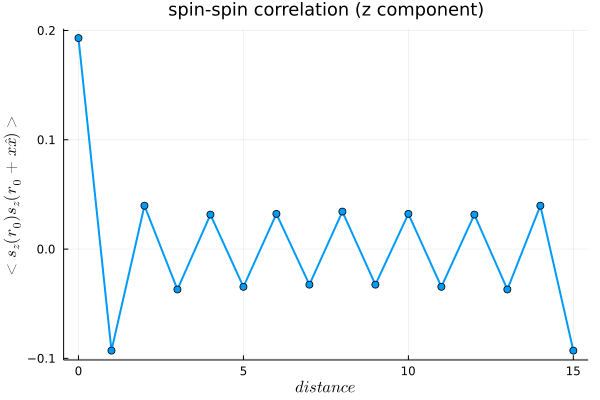

In [34]:
x_axis = collect(0:N_x-1)
plot(x_axis,correlations[4][1,:],markershape = :auto, legend=false,
    title = "spin-spin correlation (z component)",
    xlabel = L"distance",
    ylabel = L"<s_z(r_{0})s_z(r_{0}+x\hat{x})>",
    lw = 2,titlefontsize=12)

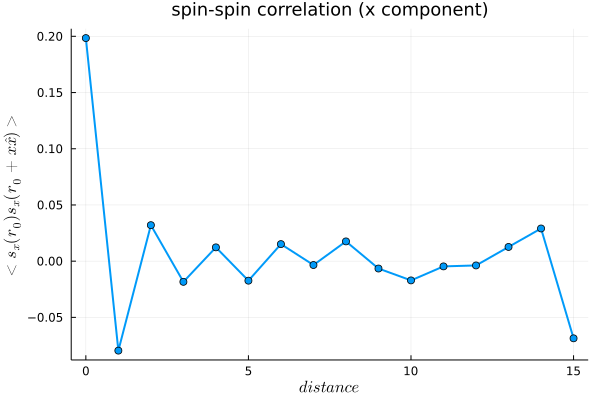

In [35]:
plot(x_axis,correlations[4][2,:],markershape = :auto,legend=false,
    title = "spin-spin correlation (x component)",
    xlabel = L"distance",
    ylabel = L"<s_x(r_{0})s_x(r_{0}+x\hat{x})>",
    lw = 2,titlefontsize=12)

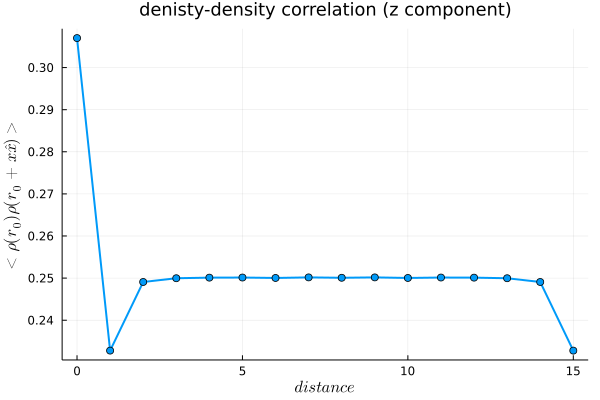

In [36]:
plot(x_axis,correlations[4][3,:],markershape = :auto,legend=false,
    title = "denisty-density correlation (z component)",
    xlabel = L"distance",
    ylabel = L"<\rho(r_{0})\rho(r_{0}+x\hat{x})>",
    lw = 2,titlefontsize=12)